In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

train_df = pd.read_csv('./data/train.csv', sep="###__###", header=None, names=['ID', 'Age', 'Gender', 'Education', 'Query_List'], encoding='utf8')
test_df = pd.read_csv('./data/test.csv', sep="###__###", header=None, names=['ID', 'Query_List'], encoding='utf8')
stopwords_df = pd.read_table('./data/cn_stopwords.txt', header=None, names=['StopWords'])
stopwords = stopwords_df['StopWords'].values

In [2]:
train_df.head(3)

,ID,Age,Gender,Education,Query_List
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只..."
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...


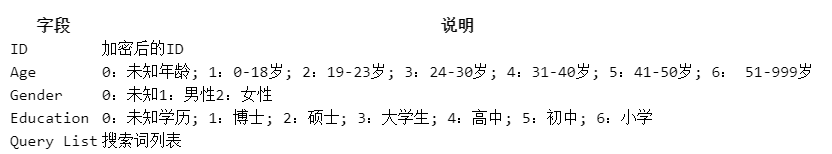

In [3]:
for column in ['Age', 'Gender', 'Education']:
    print(train_df[column].value_counts())
    print('-'*20)

1    38996
2    26744
3    18529
4    10654
5     2922
0     1666
6      489
Name: Age, dtype: int64
--------------------
1    56976
2    40869
0     2155
Name: Gender, dtype: int64
--------------------
5    37107
4    28148
3    18858
0     9280
6     5693
2      560
1      354
Name: Education, dtype: int64
--------------------


In [4]:
import re

def find_chinese(file):
    pattern = re.compile(r'[^\u4e00-\u9fa5 \t]')
    chinese_txt = re.sub(pattern,'',file)
    return chinese_txt

In [5]:
import jieba

train_age_df = train_df[['Age', 'Query_List']]
train_age_df = train_age_df[~(train_age_df['Age']==0)]  # 对缺失值直接进行删除
train_age_df['fasttext_label'] = '__label__' + train_age_df['Age'].astype(str)
train_age_df['Query_List'] = train_age_df['Query_List'].apply(lambda x: find_chinese(x))
train_age_df['Query_List'] = train_age_df['Query_List'].apply(lambda x: jieba.lcut(x))
train_age_df['Query_List'] = train_age_df['Query_List'].apply(lambda x: filter(lambda y: len(y)>1, x))
train_age_df['Query_List'] = train_age_df['Query_List'].apply(lambda x: filter(lambda y: y not in stopwords, x))
train_age_df['Query_List'] = train_age_df['Query_List'].apply(lambda x: ' '.join(x))

train_age_df.head()

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\hp\AppData\Local\Temp\jieba.cache
Loading model cost 1.111 seconds.
Prefix dict has been built successfully.


,Age,Query_List,fasttext_label
0,1,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 曹云金 再讽 郭德纲 总裁 大...,__label__1
1,2,广州 厨宝 烤箱 世情 人情 恶雨 黄昏 花易 落晓 风干 泪痕 厦门 酒店用品 批发市场 ...,__label__2
2,4,钻石 之泪 耳机 盘锦 沈阳 旅顺 公交 辽宁 阜新 车牌 盘锦 台安 网游 永生 网游 辽...,__label__4
3,4,受欢迎 狗狗 排行榜 场景 范例 三维 绘图 软件 酸奶 一起 壮观 衣服 网站 动漫 绘图...,__label__4
4,2,干槽症 自愈 太太 万岁 舒心 美国 干槽症 眼皮 下面 一直 怎么回事 麦当劳 旋风 勺子...,__label__2


In [6]:
train_age_df.shape

(98334, 3)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 1), max_features=4000).fit(train_age_df['Query_List'].iloc[:80000].values)
train_tfidf = tfidf.transform(train_age_df['Query_List'].iloc[:80000].values)
val_tfidf = tfidf.transform(train_age_df['Query_List'].iloc[80000:].values)

y_train = train_age_df['Age'].iloc[:80000].values
y_val = train_age_df['Age'].iloc[80000:].values

In [8]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

# clf = RidgeClassifier()
# clf = LogisticRegression()
clf = LGBMClassifier()
clf.fit(train_tfidf, train_age_df['Age'].iloc[:80000].values)
val_pred = clf.predict(val_tfidf)

print(f1_score(y_val, val_pred, average='macro'))

0.33566797704383317


In [9]:
clf = RidgeClassifier()
# clf = LogisticRegression()
# clf = LGBMClassifier()
clf.fit(train_tfidf, train_age_df['Age'].iloc[:80000].values)
val_pred = clf.predict(val_tfidf)

print(f1_score(y_val, val_pred, average='macro'))

0.3207561234350292


In [10]:
# clf = RidgeClassifier()
clf = LogisticRegression()
# clf = LGBMClassifier()
clf.fit(train_tfidf, train_age_df['Age'].iloc[:80000].values)
val_pred = clf.predict(val_tfidf)

print(f1_score(y_val, val_pred, average='macro'))

0.33654352964604034
